In [9]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [10]:
with open("/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl", "r") as f:
    train_data = [json.loads(line) for line in f]
train_df = pd.DataFrame(train_data)

In [13]:
# create dataset from json
from torch.utils.data import Dataset, DataLoader
import torch
import random

# set seed for same output with albumentations
random.seed(0)

class HuBMAPDataset(Dataset):
    def __init__(self, json_df:pd.DataFrame, phase:str='train', img_path:str="/kaggle/input/hubmap-hacking-the-human-vasculature/train", transforms:object=None):
        # test, valで読み込む画像を分けられるように、DataFrame形式データを引数にとる
        self.json_df = json_df
        self.img_path = img_path
        self.transforms = transforms
        self.phase = phase
        self.classes_dict = {
            "background": 0,
            "blood_vessel": 1,
            "glomerulus": 2,
            "unsure": 3,
        }
        
        if transforms:
            # min_area:指定したピクセル数より低いbboxの値は返さない
            # min_visibility:加工前のbbox領域を1とし、加工後のbbox領域が指定した領域面積割合より低ければ値を返さない
            self.bbox_params = {
                'format':"pascal_voc",
                'min_area':0,
                'min_visibility':0,
                'label_fields':['category_id']
            }
            if phase == 'test':
                self.transforms = A.Compose(transforms)
            else:
                self.transforms = A.Compose(transforms, bbox_params=self.bbox_params)
        
    def __len__(self):
        # 画像枚数を返す
        return len(self.json_df)
    
    def __getitem__(self, idx):
        sample = self.json_df['id'].iloc[idx]
        sample = sample + '.tif'
        # print(sample)
        img = cv2.imread(os.path.join(self.img_path, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # testの場合,正解データが存在しないため、処理を分ける
        if self.phase == 'test':
            if self.transforms:
                img = self.transform(self.phase, img)
            return img
            
        target_data = self.json_df.iloc[idx]
        target = self._get_target(target_data)
        # print(target)
        target['image_id'] = torch.tensor([idx])
        
        if self.transforms:
            img, target = self.transform(self.phase, img, target)
        
        # print(target)
        
        return img, target
    
    def transform(self, phase, image, target=None):
        transformed = self.transforms(image=image, masks=target['masks'], bboxes=target['boxes'], category_id=target['labels'])
        image = transformed['image']
        if phase == 'test':
            return image
        
        target['masks'] = torch.as_tensor(np.array(list(map(np.array, transformed['masks'])), dtype=np.uint8))
        target['labels'] = torch.tensor(transformed['category_id'])
        target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
        target['area'] = self._get_area(target['boxes'])
        
        return image, target
    
    def _get_target(self, target_data):
        target = self._get_target_sample()
        annotations = target_data['annotations']
        annotations = np.array(annotations)
        
        # print(annotations)
        for annotation in annotations:
            label = int(self.classes_dict[annotation['type']])
            mask = self._get_mask(label, annotation['coordinates'])
            box = self._get_box(mask)
            
            target['labels'].append(label)
            target['masks'].append(mask)
            target['boxes'].append(box)
            
        num_obj = len(target['labels'])
        target['iscrowd'] = torch.zeros((num_obj,), dtype=torch.int64)
        
        return target
    
    @staticmethod
    def _get_mask(label, coodinate):
        mask = np.zeros((512,512), dtype=np.uint8)
        # fillPolyを動かすためにnp.array型に変換 (1, N, 2)じゃないと動かない
        pts = np.array(coodinate)
        return cv2.fillPoly(mask, pts=pts, color=(1, 1, 1))
    
    @staticmethod
    def _get_box(mask):
        pos = np.nonzero(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        
        return [xmin, ymin, xmax, ymax]
    
    @staticmethod
    def _get_target_sample():
        return {
            "boxes": [],
            "masks": [],
            "area": [],
            "labels": [],
            "iscrowd": None,
            "image_id": None
        }
    
    @staticmethod
    def _get_area(boxes):
        # tensorが空の時がある
        # print(boxes)
        return (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

dataset = HuBMAPDataset(train_df)
image, target = dataset.__getitem__(0)
image.shape
# b680700d5e57:1155
target['masks'][0].shape

(512, 512)

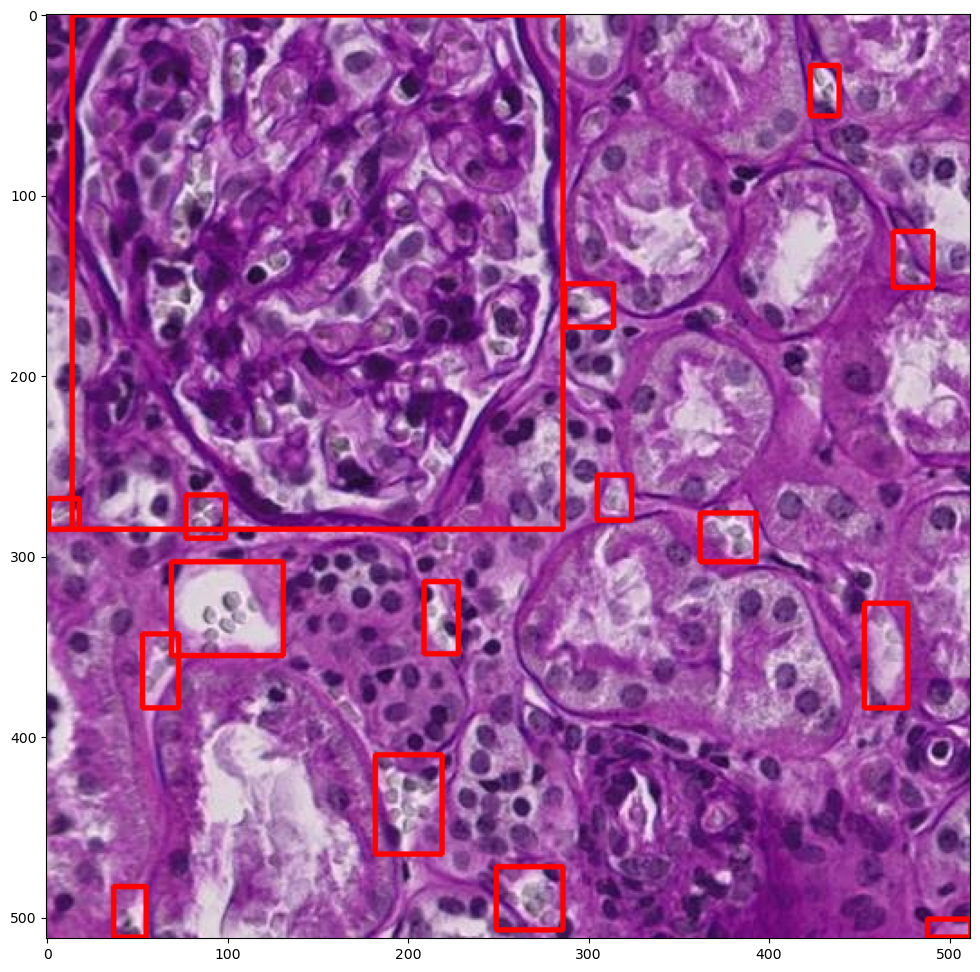

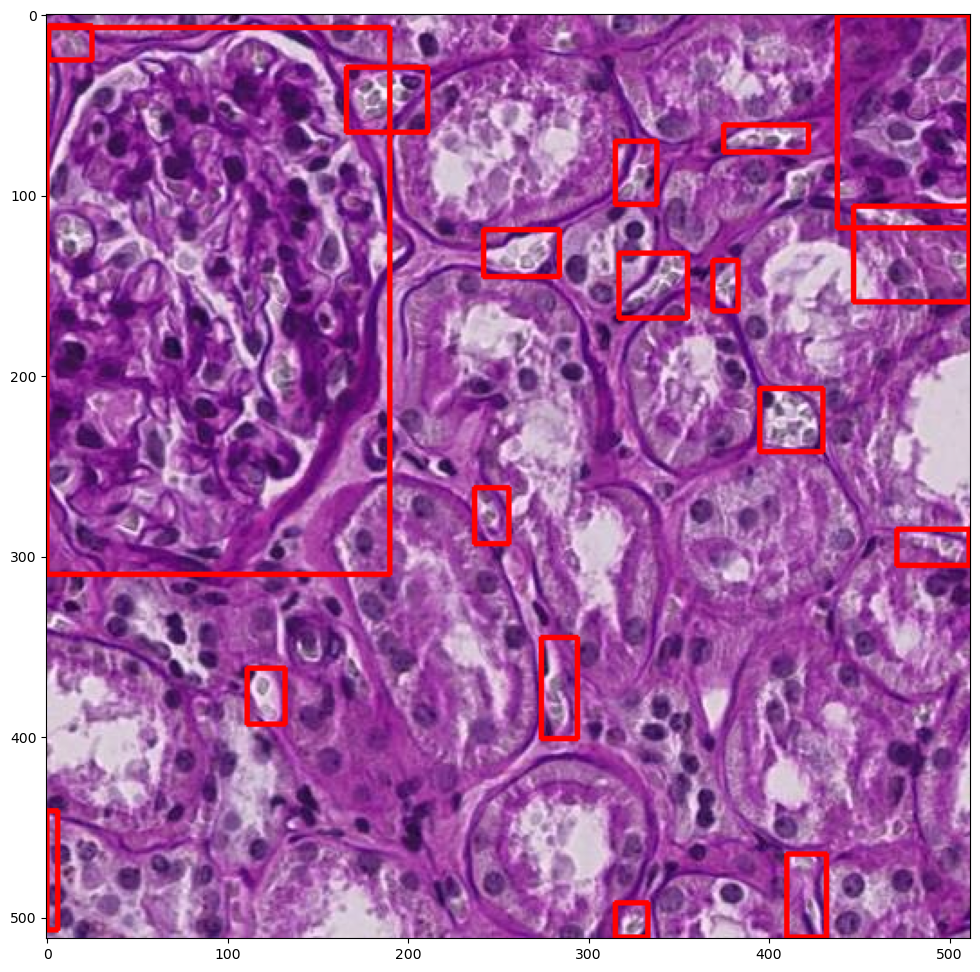

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)


In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

def fix_normalize(image, mean, std):
    for i, m in enumerate(zip(mean, std)):
        image[:,:,i] = image[:,:,i]*m[1]+m[0]
    return image

def visualize(image, bbox, label):
    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color=(255,0,0), thickness=2)
    return image

def plot_img(image, target, mean, std):
    img = image.numpy()
    img = img.transpose(1,2,0)
    img = fix_normalize(img, mean, std)
    img = img.copy()
    for bbox, label in zip(target['boxes'], target['labels']):
        img = visualize(img, bbox, label)
    
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.show()

# create transform
# decrare coco's dataset mean and std
mean=[123.675, 116.28, 103.53]
std=[58.395, 57.12, 57.375]

train_transform = [
    A.Resize(512, 512, p=1), 
    A.HorizontalFlip(),
    A.VerticalFlip(),
    # A.ShiftScaleRotate(),
    A.RandomBrightnessContrast(p=0.4),
    
    A.OneOf([
        # 被写体に動きによるブレを生じさせているように加工するフィルター
        A.MotionBlur(),
        # カーネル内の画素平均で対象ピクセルを塗りつぶす
        A.Blur(blur_limit=3),
        # メディアンフィルター、デフォルトカーネルサイズは7
        A.MedianBlur(blur_limit=3),
        # ガウスノイズを加える、チャンネル毎にノイズを乗せる
        A.GaussNoise()
    ], p=0.1),
    A.Normalize(mean, std),
    ToTensorV2()
]

validation_transform = [
    A.Resize(512, 512, p=1), 
    A.Normalize(mean, std),
    ToTensorV2()
]

test_transform = [
    A.Resize(512, 512, p=1), 
    A.Normalize(mean, std),
    ToTensorV2()
]

train, val = train_test_split(train_df, test_size=0.2, random_state=1)
train_dataset = HuBMAPDataset(train, transforms=train_transform)
val_dataset = HuBMAPDataset(val, phase='val', transforms=validation_transform)
train_dl = DataLoader(train_dataset, batch_size=5, shuffle=True, pin_memory=True, collate_fn=lambda x:tuple(zip(*x)))
val_dl = DataLoader(val_dataset, batch_size=5, shuffle=False, pin_memory=True, collate_fn=lambda x:tuple(zip(*x)))

train_img, train_target = train_dataset.__getitem__(0)
val_img, val_target = val_dataset.__getitem__(0)

plot_img(train_img, train_target, mean, std)
plot_img(val_img, val_target, mean, std)
print(train_target['masks'][0])

In [ ]:
# create mask r-cnn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN_ResNet50_FPN_V2_Weights

def get_model(num_classes:int):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

model = get_model(4)
model

In [ ]:
#import wandb

#wandb.login()
#run = wandb.init(
#    project="HuBMAP-Mask-RCNNV2",
#    config = {
#        'learning_rate':0.0035,
#        'epoch':15,
#    }
#)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim

class Trainer:
    def __init__(self, 
                 model:nn.Module, 
                 train_dl:DataLoader, 
                 val_dl:DataLoader, 
                 early_stop:dict={"monitor":'loss_mask', 'patience':5}, 
                 save_every_epoch:int=1, 
                 save_dirpath:str='/kaggle/working/runs'
                ):
        
        # callbacks:Early stopping and model checkpoint
        self.patience = early_stop['patience']
        self.monitor = early_stop['monitor']
        self.tracked_list = []
        self.save_every_epoch = save_every_epoch
        self.save_dirpath = save_dirpath
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.train_batches = len(self.train_dl)
        self.val_batches = len(self.val_dl)
        self.model = model
        self.setup_model()
        self.optim_dict = self.configure_optimizers()
        self.optimizer = self.optim_dict['optimizer']
        self.lr_scheduler = self.optim_dict['lr_scheduler']
        
        self.step_outputs = {
            'loss_objectness':0,
            'loss_mask':0,
            'loss_classifier':0,
            'loss_rpn_box_reg':0,
            'loss_box_reg':0,
            'loss':0
        }
    
    def configure_optimizers(self):
        params = [
            p for p in self.model.parameters() if p.requires_grad
        ]
        
        # optimizer = optim.SGD(params, lr=0.00018, momentum=0.938, weight_decay=0.00053)
        optimizer = optim.AdamW(params, lr=0.0001)
        lr_scheduler = optim.lr_scheduler.StepLR(
            optimizer,
            step_size=3,
            gamma=0.1
        )
        
        return {'optimizer':optimizer, 'lr_scheduler':lr_scheduler}
    
    def setup_model(self):
        for param in self.model.parameters():
            param.requires_grad = True
        self.model.to(self.device)
        self.model.train()
        
    def train(self, max_epoch:int):
        for epoch in range(1, max_epoch + 1):
            print('{}/{}'.format(epoch, max_epoch+1))
            print('-'*10)
            
            for batch_idx, batch in tqdm(enumerate(self.train_dl, 1), desc='Training', total=self.train_batches):
                outputs = self.training_step(batch)
                for key, value in outputs.items():
                    self.step_outputs[key] += float(value.detach().cpu().numpy()) / self.train_batches
            self.on_train_epoch_end(epoch)
            
            for batch_idx, batch in tqdm(enumerate(self.val_dl, 1), desc='Validation', total=self.val_batches):
                outputs = self.validation_step(batch)
                for key, value in outputs.items():
                    self.step_outputs[key] += float(value.detach().cpu().numpy()) / self.val_batches
            
            tracked_loss, patience = self.on_validation_epoch_end(epoch)
            
            if epoch % self.save_every_epoch == 0:
                if not os.path.exists(self.save_dirpath):
                    os.mkdir(self.save_dirpath)
                path = os.path.join(self.save_dirpath, f"epoch_{epoch}_{self.monitor}_{tracked_loss:.2f}.pth")
                torch.save(model.state_dict(), path) 
                print("\nThe model passed the save checkpoint successfully!\n")
            
            if patience == 0:
                print("Our patience has run out! Model training stopped beforehand.")
                break
            
    def training_step(self, batch):
        images, targets = self.to_device(batch)
        self.optimizer.zero_grad()
        outputs = self.model(images, targets)
        loss = sum([loss for loss in outputs.values()])
        outputs['loss'] = loss
        loss.backward()
        self.optimizer.step()
        return outputs
    
    def validation_step(self, batch):
        images, targets = self.to_device(batch)
        with torch.no_grad():
            outputs = self.model(images, targets)
            loss = sum([loss for loss in outputs.values()])
            outputs['loss'] = loss
        return outputs
        
    def to_device(self, batch):
        images, targets = batch
        images = list(image.to(self.device) for image in images)
        
        targets = [
            {key:value.to(self.device) for key, value in target.items()}
            for target in targets
        ]
        
        return images, targets
    
    def on_train_epoch_end(self, epoch:int):
        return self.shared_epoch_end(stage='train', epoch=epoch)
    
    def on_validation_epoch_end(self, epoch:int):
        tracked_loss = self.shared_epoch_end(stage='val', epoch=epoch)
        patience = 0
        
        if epoch > self.patience:
            last_tracked = list(reversed(self.tracked_list))[:self.patience]
            for i in last_tracked:
                if i <= tracked_loss:
                    patience += 1
                    
        self.tracked_list.append(tracked_loss)
        
        return tracked_loss, (self.patience - patience)
    
    def shared_epoch_end(self, stage:str, epoch:int):
        tracked_loss = self.step_outputs[self.monitor]
        loss_objectness = self.step_outputs['loss_objectness']
        loss_mask = self.step_outputs['loss_mask']
        loss_classifier = self.step_outputs['loss_classifier']
        loss_rpn_box_reg = self.step_outputs['loss_rpn_box_reg']
        loss_box_reg = self.step_outputs['loss_box_reg']
        loss = self.step_outputs['loss']
        
        #wandb.log({
        #    f"{stage}_loss_objectness": loss_objectness,
        #    f"{stage}_loss_mask": loss_mask,
        #    f"{stage}_loss_classifier": loss_classifier,
        #    f"{stage}_loss_rpn_box_reg": loss_rpn_box_reg,
        #    f"{stage}_loss_box_reg": loss_box_reg,
        #    f"{stage}_loss": loss  
        #})
        
        print(
            f"""
            || End {epoch} {stage} epoch ||
            loss_objectness: {loss_objectness:.2f}
            loss_mask: {loss_mask:.2f}
            loss_classifier: {loss_classifier:.2f}
            loss_rpn_box_reg: {loss_rpn_box_reg:.2f}
            loss_box_reg: {loss_box_reg:.2f} 
            loss: {loss:.2f}\n
            """
        )
        
        self.step_outputs = self.step_outputs.fromkeys(self.step_outputs, 0)
        if stage == 'train':
            self.lr_scheduler.step()
            
        if stage == 'val':
            return tracked_loss
                
trainer = Trainer(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    early_stop = {"monitor": "loss_mask", "patience": 5},
    save_every_epoch=1
)

In [ ]:
trainer.train(max_epoch=15)